# Usage

This notebook shows how to use the `osculari` package.

The `osculari` package consists of three main `modules`:
* `models`: to readout pretrained networks and add linear layers on top of them.
* `datasets`: to create datasets and dataloaders to train and test linear probes.
* `paradigms`: to implement psychophysical paradigms to experiment with deep networks.

[![](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/ArashAkbarinia/osculari/blob/main/docs/source/notebooks/usage.ipynb)

If you are running this notebook on Google Colab, install osculari by uncommenting and executing
the cell below.

In [1]:
# !pip install osculari

In [2]:
# importing required packages
import osculari
from osculari import models, datasets, paradigms

import numpy as np
import requests
from matplotlib import pyplot as plt
from PIL import Image as pil_image
import torch
import torchvision.transforms as torch_transforms

## `osculari.models`

### Supported models
To check which models are supported by `osculari`, call the `available_models()` function,
which returns a dictionary corresponding to different datasets/environments:
* imagenet
* segmentation
* taskonomy
* clip
Each item in the dictionary contains a list of supported pretrained networks.

Calling the `available_models(flatten=True)` returns a list of all supported models without
splitting them into datasets/environments.

In [73]:
models.available_models()

{'imagenet': ['alexnet',
  'convnext_base',
  'convnext_large',
  'convnext_small',
  'convnext_tiny',
  'densenet121',
  'densenet161',
  'densenet169',
  'densenet201',
  'efficientnet_b0',
  'efficientnet_b1',
  'efficientnet_b2',
  'efficientnet_b3',
  'efficientnet_b4',
  'efficientnet_b5',
  'efficientnet_b6',
  'efficientnet_b7',
  'efficientnet_v2_l',
  'efficientnet_v2_m',
  'efficientnet_v2_s',
  'googlenet',
  'inception_v3',
  'maxvit_t',
  'mnasnet0_5',
  'mnasnet0_75',
  'mnasnet1_0',
  'mnasnet1_3',
  'mobilenet_v2',
  'mobilenet_v3_large',
  'mobilenet_v3_small',
  'regnet_x_16gf',
  'regnet_x_1_6gf',
  'regnet_x_32gf',
  'regnet_x_3_2gf',
  'regnet_x_400mf',
  'regnet_x_800mf',
  'regnet_x_8gf',
  'regnet_y_128gf',
  'regnet_y_16gf',
  'regnet_y_1_6gf',
  'regnet_y_32gf',
  'regnet_y_3_2gf',
  'regnet_y_400mf',
  'regnet_y_800mf',
  'regnet_y_8gf',
  'resnet101',
  'resnet152',
  'resnet18',
  'resnet34',
  'resnet50',
  'resnext101_32x8d',
  'resnext101_64x4d',
  'res

### Pretrained networks

The main entry to pretrained networks is the `models.readout` submodule, which supports several
functionalities.

#### Feature extraction

To extract features from a pretrained network at a specific layer, call the `FeatureExtractor`
class, passing the following arguments:
* `architecture` is the network's architecture you want to load (e.g. `resnet50` or `vit_b_32`).
It should be one of the items from the available models we mentioned above.
* `weights` defines the pretrained weights. It can be one of the following formats:
  - Path to a local file.
  - Downloadable URL of the pretrained weights.
  - A string corresponding to the available weight, for instance, [PyTorch resnet50](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html) supports one
of the following strings: \["*DEFAULT*", "*IMAGENET1K_V1*", "*IMAGENET1K_V2*"\].
  - The same name as `architecture` which loads the network's default weights.
* `layers` determines the read-out (cut-off) layer(s). Which layers are available for each network
can be obtained by calling the `models.available_layers()` function.

In this example, we extract features from the first block of ResNet50, using the default
weights.

In [4]:
architecture = 'resnet50'        # networks' architecture
weights = 'resnet50'             # the pretrained weights
layer = 'block0'                 # the readout layer
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture, 
    'weights': weights,
    'layers': layer,
}
feature_extractor = models.FeatureExtractor(**readout_kwargs)
print(feature_extractor)

FeatureExtractor(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
)


Let's open an image and test our `feature_extractor`. We should convert
the image into a torch tensor. Each pretrained network has its own `mean` and `std` for
normalisation. These values are available from the class variable `normalise_mean_std`.

Shape of the input image: torch.Size([1, 3, 224, 224])


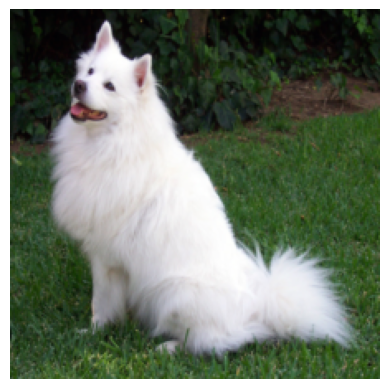

In [5]:
# reading an image
url = 'https://github.com/pytorch/hub/raw/master/images/dog.jpg'
input_img = pil_image.open(requests.get(url, stream=True).raw)

img_size = 224
mean, std = feature_extractor.normalise_mean_std
# converting it to torch tensor
transforsm = torch_transforms.Compose([
    torch_transforms.Resize((img_size, img_size)),
    torch_transforms.ToTensor(),
    torch_transforms.Normalize(mean=mean, std=std)
])
torch_img = torch.stack([transforsm(input_img)])
print('Shape of the input image:', torch_img.shape)

# visualising the image that will be input to the network
img_vis = torch_img.numpy().squeeze().transpose(1, 2, 0) * std + mean
img_vis = np.maximum(np.minimum(img_vis, 1), 0)
plt.imshow(img_vis)
plt.axis('off')
plt.show()

We can now extract features for our image. Note that `feature_extractor` is like
any other `torch.nn.Module` and is callable. In this exampple, we input the network
with one image, but multiple images can also be input.

In [6]:
# extragin the features
features = feature_extractor(torch_img)
print('Shape of the extracted features:', features.shape)

Shape of the extracetd features: torch.Size([1, 64, 56, 56])


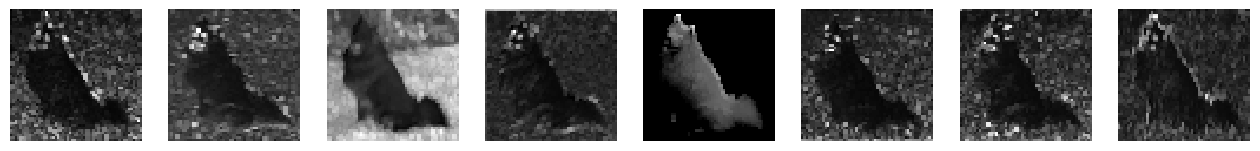

In [7]:
# visualising 8 of the extracted features
fig = plt.figure(figsize=(16, 4))
for i in range(8):
    ax = fig.add_subplot(1, 8, i+1)
    ax.matshow(features[0, i].detach().numpy(), cmap='gray')
    ax.axis('off')

#### Pooling

From the feature extractor example, we can observe that the dimensionality of the 
extracted features might be too large–a vector of $200704$ elements ($64 \times 56 \times 56$)–
to input directly to a linear classifier.
It might be beneficial to reduce this using pooling operations that do not have
extra parameters to learn. We can achieve this by passing the `'pooling'` parameter.

In this example, we pass `'pooling': 'avg_2_2'` (i.e., adaptive average pooling with
a $2 \times 2$ output size. We can see that the extracted features are only $256$ elements 
($64 \times 2 \times 2$).

In [26]:
architecture = 'resnet50'        # networks' architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                 # the readout layer
pooling = 'avg_2_2'              # whether reduce the spatial resolution of features by pooling
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture, 
    'weights': weights,
    'layers': layer,
    'pooling': pooling 
}
feature_extractor = models.FeatureExtractor(**readout_kwargs)

# extracting features
features = feature_extractor(torch_img)
print('Shape of the extracted features with pooling:', features.shape)

Shape of the extracted features with pooling: torch.Size([1, 1, 64, 2, 2])


From the print above you can note that the output contains five dimensions:
1. batch size, in this example 1.
2. Corresponding to the number of pooling operations, which we explain below.
3. Number of kernels, in this example 64.
4. Width of spatial resolution.
5. Height of spatial resolution.

Currently, we support two pooling operations: `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`.
The `'pooling'` parameter can be one of the following formats:
* `avg_x_y`: applying an adaptive average pooling with a $x \times y$ output size,
* `max_x_y`: applying an adaptive max pooling,
* `maxavg_x_y` or `avgmax_x_y`: applying both pooling operations; under this scenario the
output's second dimension will be 2 always in this order: average pooling is always first.

#### Linear probing

Linear probing is a powerful and flexible technique for interpreting intermediate
representation in deep networks. This consists of adding a linear layer on top of 
the features extracted from a frozen pretrained network. This can be easily archived
by inheriting the `readout.ProbeNet` class.

For instance, let's say we want to perform a 2AFC task, we can implement `Classifier2AFC`
class:
* `input_nodes=2` specifies that the number of input images passed to the linear classifier is two.
* `num_classes=2` denotes that the linear classifier outputs two numbers.
* We should implement the `forward` function. In this example, we extract features from two inputs and concatenate them into one vector, which is input to the probe layer.

Other custom paradigms are easily achieved by changing the `input_nodes`, `num_classes` and 
`forward` function.

In [16]:
class Classifier2AFC(models.readout.ProbeNet):
    def __init__(self, **kwargs) -> None:
        super(Classifier2AFC, self).__init__(input_nodes=2, num_classes=2, **kwargs)

    def forward(self, x0, x1):
        x0 = self.do_features(x0)
        x1 = self.do_features(x1)
        x = torch.cat([x0, x1], dim=1)
        return self.do_probe_layer(x)

Let's make an instance of the `Classifier2AFC` we just created.

In [17]:
architecture = 'resnet50'        # networks' architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                 # the readout layer
pooling = None                   # whether reduce the spatial resolution of features by pooling
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture, 
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling 
}
net_2afc = Classifier2AFC(**readout_kwargs)
print(net_2afc)

Classifier2AFC(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=401408, out_features=2, bias=True)
)


After printing the `net_2afc`, we can see that the `Classifier2AFC` network contains two nodes: 
* **backbone**
* **fc**

corresponding to the pretrained network and linear classifier, respectively.

Now, we can call our `net_2afc` with two images.

Of course, the linear layer should be trained on some tasks to obtain meaningful results. Please
check the [examples page](https://osculari.readthedocs.io/en/latest/examples.html) of our 
documentation.

In [18]:
output = net_2afc(torch_img, torch_img)
print("Shape of the Classifier2AFC output:", output.shape)

Shape of the Classifier2AFC output: torch.Size([1, 2])


#### Predefined paradigms

Common paradigms like 2AFC are already implemented. For instance, using the
`models.paradigm_2afc_merge_concatenate` function results in a similar network
we implemented above. Check the [models documentation](https://osculari.readthedocs.io/en/latest/osculari.models.html#module-osculari.models.readout)
to see all paradigms already implemented.

In [27]:
architecture = 'resnet50'        # networks' architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                 # the readout layer
pooling = None                   # whether reduce the spatial resolution of features by pooling
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture, 
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling 
}
net_2afc = models.paradigm_2afc_merge_concatenate(**readout_kwargs)
print(net_2afc)

Classifier2AFC(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=401408, out_features=2, bias=True)
)


## `osculari.datasets`

The linear probe layer must be trained on some data to obtain meaningful results.
The training dataset highly depends on the feature one is interested in studying.
Nevertheless, the `datasets` module implements a few generic datasets that are
helpful in many scenarios.

### ShapeAppearanceDataset

The `datasets.ShapeAppearanceDataset` implements a generic foreground-background
images allowing an easy interface to manipulate foreground appearance and merge
it into the background. To achieve this, pass a `merge_fg_bg` function to this dataset.

Let's make an example, where we create four images for an **odd-one-out** task based on 
the object's colour.

In [31]:
def odd_one_colour(fgs, bgs):
    """Merging foreground masks (fgs) into background images (bgs)."""
    num_imgs = len(fgs)
    gt = np.random.randint(0, num_imgs)
    colour0 = datasets.dataset_utils.random_colour()
    colour1 = datasets.dataset_utils.random_colour()
    colours = [colour0 if g == gt else colour1 for g in range(num_imgs)]
    imgs = []
    for i in range(num_imgs):
        img = bgs[i].copy()
        for c in range(3):
            chn = img[..., c]
            chn[fgs[i]] = colours[i][c] / 255
            img[..., c] = chn
        imgs.append(img)
    return imgs, gt

In [58]:
num_samples = 1000               # the number of random samples generated in the dataset
num_imgs = 4                     # the number of images in each sample
background = 128                 # the background type
merge_fg_bg = odd_one_colour     # the function in charge of merging foreground and background
dataset = datasets.ShapeAppearanceDataset(
    num_samples, num_imgs, img_size, background, merge_fg_bg,
)

The `merge_fg_bg` decides the output of `__getitem__` function. In this example,
we return four images and one ground-truth.

In [72]:
db_out = dataset.__getitem__(i)
print('Number of elements in dataset output:', len(db_out))
imgs = db_out[:-1]
gt = db_out[-1]
print('Images spatial resolution:', [el.shape for el in imgs])
print('Ground-truth:', gt)

Number of elements in dataset output: 5
Images spatial resolution: [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]
Ground-truth: 1


Let's get a few items from our dataset and visualise them:

In [59]:
def plot_dataset(dataset, num_sampels, title):
    fig = plt.figure(figsize=(16, num_sampels+1))
    fig.suptitle(title, fontsize=20, fontweight='bold')
    for i in range(num_sampels):
        db_out = dataset.__getitem__(i)
        imgs = db_out[:-1]
        ax = fig.add_subplot(num_sampels//2, 2, i+1)
        ax.set_title('GT (odd-one-image): %d' % db_out[-1], fontsize=16)  
        ax.imshow(np.concatenate(imgs, axis=1))
        ax.axis('off')

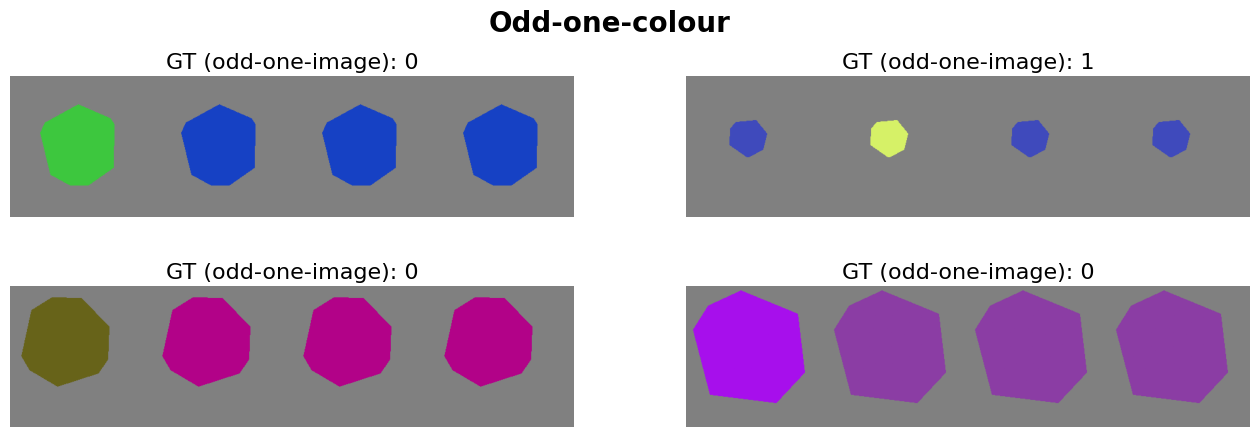

In [60]:
plot_dataset(dataset, 4, 'Odd-one-colour')

Several aspects of the `ShapeAppearanceDataset` can easily be modified including.
Let's look at a few example:

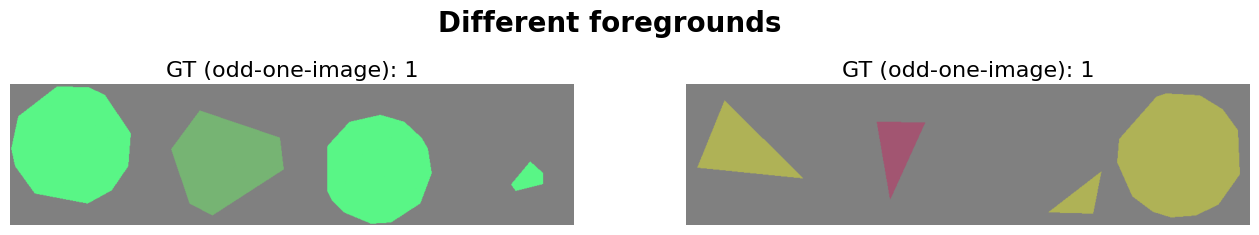

In [61]:
# making the foreground shapes different
dataset = osculari.datasets.ShapeAppearanceDataset(
    num_samples, num_imgs, img_size, background, merge_fg_bg,
    unique_fg_shape=False
)
plot_dataset(dataset, 2, 'Different foregrounds')

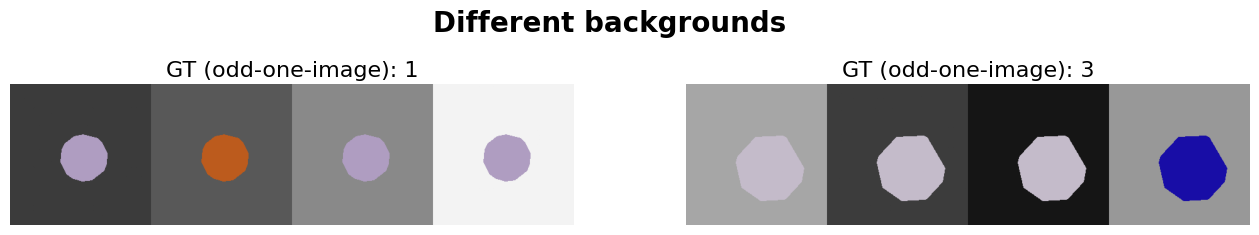

In [64]:
# making the foreground shapes different
dataset = datasets.ShapeAppearanceDataset(
    num_samples, num_imgs, img_size, merge_fg_bg=merge_fg_bg,
    background='uniform_achromatic', unique_bg=False
)
plot_dataset(dataset, 2, 'Different backgrounds')

## `osculari.paradigms`

Similar to the training dataset of the linear probe layer, the procedure to train/test this 
layer is also task-dependent.
Nevertheless, the `paradigms` module implements a few generic train/test routines that are
useful in many scenarios.

### Training

The `paradigms.train_linear_probe` function offers generic training for the linear layer.

The following arguments must be passed to this function:
 * `model`: for instance the `net_2afc` we created above.
 * `dataset`: for instance the `dataset we create above.
 * `epoch_loop`: a callable function that processes an epoch of data. Several paradigms
already implement such a function (e.g., `paradigms.forced_choice.epoch_loop` that handles any
alternative-forced-choice task, such as 2AFC and 4AFC). Alternatively, you can implement a
custom function yourself.
 * `out_dir`: to save the checkpoints.

The following arguments are optional (a reasonable default exists for them):
 * `optimiser` \[default is SGD with $lr=0.1$\].
 * `epochs` \[default is 10\].
 * `scheduler` \[default is `MultiStepLR` at 50 and 80% of epochs\].

The `paradigms.train_linear_probe` save the checkpoints and return the log values for all epochs
(i.e., each epoch log is a `Dict` the output of the `epoch_loop` function).

Please check the [examples page](https://osculari.readthedocs.io/en/latest/examples.html) of our 
documentation that showcases a few notebooks using this function.

### Psychophysics

Finally, once the linear probe is trained, we can conduct the psychophysical
experiments with it to learn more about the internal representation of deep networks.

The `paradigms` module also implements a set of common psychophysical experiments similar to the
experiments conducted with human participants. For instance, the `paradigms.staircase` function
implements the staircase procedure to measure the sensitivity threshold by adjusting the
value of the features we are interested in studying.

Please check the [paradigms documentation](https://osculari.readthedocs.io/en/latest/osculari.paradigms.html)
to see all psychophysical paradigms already implemented.

Please check the [examples page](https://osculari.readthedocs.io/en/latest/examples.html) of our 
documentation that showcases a few notebooks using this function.